In [0]:
# helper to download the Data Set from Google Drive

import requests
import os

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [0]:
# Download the pre processed data set
file_id = '1snoB3mte3eyzYOEQTJAaRWz7M-7cJMjb'

destination = 'RAVDESS_train.zip'

if not os.path.exists(destination):
    download_file_from_google_drive(file_id, destination)

In [142]:
!ls -lh

total 154M
drwxr-xr-x 3 root root 4.0K Dec 15 13:38 RAVDESS
-rw-r--r-- 1 root root 154M Dec 15 13:38 RAVDESS_train.zip
drwxr-xr-x 1 root root 4.0K Dec 12 16:48 sample_data


In [144]:
!unzip RAVDESS_train.zip

Archive:  RAVDESS_train.zip
replace RAVDESS/train_valid/test/fearful/03-01-06-02-01-01-05-100.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace RAVDESS/train_valid/test/fearful/03-01-06-02-01-02-07-0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: RAVDESS/train_valid/test/fearful/03-01-06-02-01-02-07-0.png  
  inflating: RAVDESS/train_valid/test/fearful/03-01-06-01-02-01-10-217.png  
  inflating: RAVDESS/train_valid/test/fearful/03-01-06-01-01-01-12-413.png  
  inflating: RAVDESS/train_valid/test/fearful/03-01-06-02-01-02-12-348.png  
  inflating: RAVDESS/train_valid/test/fearful/03-01-06-01-02-01-18-0.png  
  inflating: RAVDESS/train_valid/test/fearful/03-01-06-01-02-01-03-200.png  
  inflating: RAVDESS/train_valid/test/fearful/03-01-06-02-02-01-03-306.png  
  inflating: RAVDESS/train_valid/test/fearful/03-01-06-01-02-02-08-100.png  
  inflating: RAVDESS/train_valid/test/fearful/03-01-06-01-01-01-11-205.png  
  inflating: RAVDESS/train_valid/test/fearful/03-01-06-01-02-01

In [145]:
!ls RAVDESS/train_valid/test -lh

total 32K
drwxr-xr-x 2 root root 4.0K Dec 15 16:39 angry
drwxr-xr-x 2 root root 4.0K Dec 15 16:39 calm
drwxr-xr-x 2 root root 4.0K Dec 15 16:39 disgust
drwxr-xr-x 2 root root 4.0K Dec 15 16:39 fearful
drwxr-xr-x 2 root root 4.0K Dec 15 16:39 happy
drwxr-xr-x 2 root root 4.0K Dec 15 16:39 neutral
drwxr-xr-x 2 root root 4.0K Dec 15 16:39 sad
drwxr-xr-x 2 root root 4.0K Dec 15 16:39 surprised


In [0]:
import numpy as np
import pandas as pd
import librosa
from scipy.signal import spectrogram
import math
import matplotlib.pyplot as plt
import seaborn as sn
import random
import re
import gc
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
# create directory path helper variables
base_dir = 'RAVDESS/train_valid/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [0]:
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras import backend as K
from keras.layers import Flatten
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
resnet_img_height=128
resnet_img_width=128

In [151]:
# using a pretrained resnet model, dowloading without the top layers
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(resnet_img_height,resnet_img_width,3))
for layer in base_model.layers:
    layer.trainable = True

# adding the top layers for classification  
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)
model = Model(base_model.input, predictions)
model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
# compile the model, with rmsprop optimizer
model.compile(optimizer='rmsprop', metrics=['accuracy'], loss='categorical_crossentropy')

# add callbacks for early stopping
checkpointer = ModelCheckpoint(filepath='bestmodel.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

In [153]:
print("Number of original train images: " + str(sum([len(files) for r, d, files in os.walk(train_dir)])))
print("Number of original validation images: " + str(sum([len(files) for r, d, files in os.walk(validation_dir)])))
print("Number of original test images: " + str(sum([len(files) for r, d, files in os.walk(test_dir)])))

Number of original train images: 4931
Number of original validation images: 615
Number of original test images: 621


In [154]:
# Load the images with ImageDataGenerator. The original images are not augmented as we have a fixed time series images. The Image is rescaled to 0..1 range.
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0, width_shift_range=0, height_shift_range=0, zoom_range=0, horizontal_flip=False, vertical_flip=False)
validation_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0, width_shift_range=0, height_shift_range=0, zoom_range=0, horizontal_flip=False, vertical_flip=False)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(resnet_img_height, resnet_img_width), batch_size=32, class_mode='categorical', seed=42)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(resnet_img_height, resnet_img_width), batch_size=32, class_mode='categorical', seed=42)

Found 4931 images belonging to 8 classes.
Found 615 images belonging to 8 classes.


In [155]:
# The model used the train generator to load and randomize the data. 
model.fit(train_generator,steps_per_epoch=5,validation_data=validation_generator,validation_steps=10,epochs=150, callbacks=[checkpointer, earlystopper])

Epoch 1/150
5/5 [==============================] - 102s 20s/step - loss: 4.0817 - acc: 0.1812 - val_loss: 4.5255 - val_acc: 0.1156

Epoch 00001: val_loss improved from inf to 4.52549, saving model to bestmodel.hdf5
Epoch 2/150
5/5 [==============================] - 78s 16s/step - loss: 4.2249 - acc: 0.1125 - val_loss: 3.0001 - val_acc: 0.1864

Epoch 00002: val_loss improved from 4.52549 to 3.00012, saving model to bestmodel.hdf5
Epoch 3/150
5/5 [==============================] - 81s 16s/step - loss: 3.1302 - acc: 0.2375 - val_loss: 3.1796 - val_acc: 0.1812

Epoch 00003: val_loss did not improve from 3.00012
Epoch 4/150
5/5 [==============================] - 78s 16s/step - loss: 2.7129 - acc: 0.1875 - val_loss: 2.3629 - val_acc: 0.1932

Epoch 00004: val_loss improved from 3.00012 to 2.36293, saving model to bestmodel.hdf5
Epoch 5/150
5/5 [==============================] - 80s 16s/step - loss: 2.9395 - acc: 0.1812 - val_loss: 5.1543 - val_acc: 0.2156

Epoch 00005: val_loss did not improv

In [163]:
# loading back the best model
saved_model = load_model('bestmodel.hdf5')

train_evaluated = saved_model.evaluate(train_generator)
validation_evaluated = saved_model.evaluate(validation_generator)
print('Training Accuracy: %.3f%%, Training Loss: %.3f' % (train_evaluated[1]*100, train_evaluated[0]))
print('Validation Accuracy: %.3f%%, Validation Loss: %.3f' % (validation_evaluated[1]*100, validation_evaluated[0]))

20/20 [==============================] - 55s 3s/step
Training Accuracy: 26.181%, Training Loss: 2.061
Validation Accuracy: 26.341%, Validation Loss: 2.036


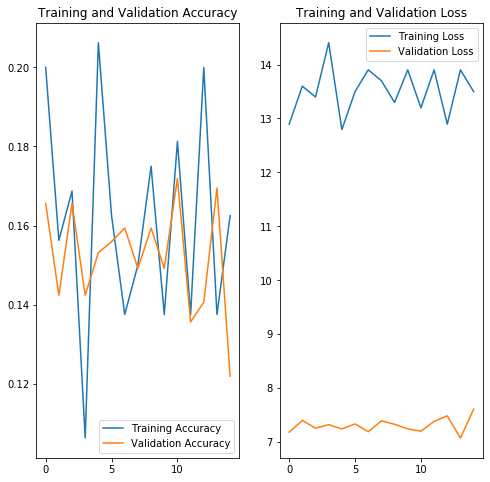

In [164]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [185]:
test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0, width_shift_range=0, height_shift_range=0, zoom_range=0, horizontal_flip=False, vertical_flip=False)
test_generator = test_datagen.flow_from_directory(test_dir, shuffle=False, target_size=(resnet_img_height, resnet_img_width), batch_size=32, class_mode='categorical', seed=42)

#Confusion Matrix
Y_pred = model.predict_generator(test_generator)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
emotions_confusion_matrix = confusion_matrix(test_generator.classes, y_pred)
print(emotions_confusion_matrix)


Found 621 images belonging to 8 classes.
[[0.01080788 0.90918064 0.01135529 ... 0.01065379 0.01768888 0.00144247]
 [0.1459216  0.07088853 0.16229035 ... 0.02895154 0.11700387 0.17106526]
 [0.12120117 0.14331357 0.16477808 ... 0.06354229 0.15590148 0.11424052]
 ...
 [0.24070896 0.00544352 0.06202262 ... 0.00387344 0.06278875 0.15601398]
 [0.10280794 0.08572184 0.18027687 ... 0.02419715 0.10455766 0.15617004]
 [0.03807598 0.5889036  0.04251264 ... 0.06775305 0.06195157 0.01332177]]
[[19 53  3  8  2  0  0  1]
 [ 0 83  6  0  0  0  1  0]
 [17 56 12  9  0  0  2  0]
 [ 9 48  2 20  0  0  0  0]
 [ 9 49  6 11  1  0  0  1]
 [ 1 30  3  2  0  0  0  0]
 [ 3 69  7  6  0  0  1  1]
 [ 4 40  5 21  0  0  0  0]]


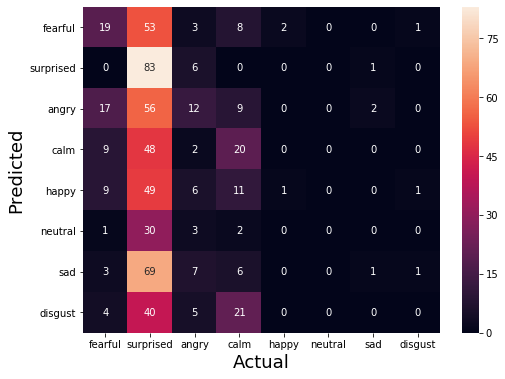

In [190]:
emotions = os.listdir(test_dir)
emotion_confusion_df = pd.DataFrame(emotions_confusion_matrix, index = emotions,
                  columns = emotions)
plt.figure(figsize = (8,6))
sn.heatmap(emotion_confusion_df, annot=True)
plt.xlabel('Actual', fontsize=18)
plt.ylabel('Predicted', fontsize=18)
plt.show()